<a href="https://colab.research.google.com/github/analluvias/-Natural-Language-Processing-with-Transformers/blob/cap-4/capitulo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER PARA DATASETS MULTILÍNGUES

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

## Conhecendo os datasets

Vamos utilizar o XTREME do benchmark XTREME, PAN-X.

que consiste de artigos da wikipedia em muitas linguagens, incluindo alemão, francês, italiano e inglês

In [2]:
 from datasets import get_dataset_config_names
 xtreme_subsets = get_dataset_config_names("xtreme")
 print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

XTREME has 183 configurations


## buscando apenas aqueles datasets que começam com PAN

In [3]:
 panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
 panx_subsets[:3] # PRINTANDO OS ÚLTIMOS 3

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

### É notável que existem um padrão PAN-X. um sufixo de duas letras, o que parece estar no padrão ISO 639-1 language code. para carregar o corpus alemão, então:

In [4]:
 from datasets import load_dataset
 load_dataset("xtreme", name="PAN-X.de")

train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

### Na nossa atividade proposta, vamos simular estar performando um NER para um cliente da Suíça, cujas linguagens são alemão, francês, italiano e inglês, nas seguintes proporções: German (62.9%), French (22.9%), Italian (8.4%), and English (5.9%)

vamos então pegar amostragens das línguas de acodo com a proporção de falantes na vida real, isso vai criar um desbalanceamente que é comum na vida real. E vamos poder ver como criar um modelo que funcione em todas as linguagens.

In [5]:
from collections import defaultdict # Importa a classe defaultdict do módulo collections, que permite criar dicionários com valores padrão.
from datasets import DatasetDict # Importa a classe DatasetDict do módulo datasets, que é usada para armazenar conjuntos de dados.

langs = ["de", "fr", "it", "en"] # Define uma lista de códigos de idioma (alemão, francês, italiano e inglês).
fracs = [0.629, 0.229, 0.084, 0.059] # Define uma lista de frações correspondentes a cada idioma, que serão usadas para subamostrar os conjuntos de dados.

# Cria um defaultdict (dicionário com valores padrão) que armazenará DatasetDicts.
# Se uma chave (idioma) não existir, um novo DatasetDict será criado automaticamente.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs): # Itera sobre os idiomas e suas frações correspondentes.
    # Carrega o corpus monolíngue do XTREME para o idioma atual.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")

    # Itera sobre os splits (divisões) do conjunto de dados (por exemplo, "train", "validation", "test").
    for split in ds:
        # Embaralha o conjunto de dados atual (split) com uma semente fixa (seed=0) para reprodutibilidade.
        # Seleciona uma subamostra do conjunto de dados embaralhado, com base na fração correspondente ao idioma.
        # Armazena o subconjunto no dicionário panx_ch, usando o idioma e o split como chaves.
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows)))
        )

train-00000-of-00001.parquet:   0%|          | 0.00/837k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/932k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/459k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/464k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

### vamos ver quantos exemplos temos por língua

In [6]:
 import pandas as pd


 pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
 index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


### Pela porcentagem que selecionamos, temos mais exemplos em alemão, do que em todas as outras linguas combinafdas. vamos usar o subdataset em alemão para performar o zero-shot cross lingual transfer, com fr, it e en

#### vejamos um exemplo em alemão

In [7]:
 element = panx_ch["de"]["train"][0]
 for key, value in element.items():
     print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


### a coluna ner_tags representa ao mapeamente da entidade a uma classe, mas como é difícil de identificar pelo ID, vamos fazer a correspondência pelo nome da chave


#### vejamos primeiro, em alemão, a lista de features

In [8]:
for key, value in panx_ch["de"]["train"].features.items():
 print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


#### podemos ver que as classes estão dentro de ClassLabel, vamos escolher ela

In [9]:
 tags = panx_ch["de"]["train"].features["ner_tags"].feature
 print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


#### agora, poderemos usar ClassLabelint2str() para criar uma nova coluna no nosso dataset de treino, com o nome da classe de cada tag.

usaremos o método map para retornar um dicionário com a chave correspondente ao novo nome da coluna e o valor como uma lista dos nomes das classes

In [10]:
def create_tag_names(batch):
    # Esta função recebe um lote (batch) de dados como entrada.
    # O lote contém uma coluna chamada "ner_tags", que são os índices numéricos das etiquetas (tags) de NER (Named Entity Recognition).

    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}
    # A função retorna um dicionário com uma nova chave "ner_tags_str".
    # O valor associado a essa chave é uma lista de strings, onde cada string é o nome da etiqueta (tag) correspondente ao índice numérico em "ner_tags".
    # A função tags.int2str(idx) é usada para converter o índice numérico em seu nome de etiqueta (tag) correspondente.

panx_de = panx_ch["de"].map(create_tag_names)
# Esta linha aplica a função create_tag_names a cada lote (batch) do conjunto de dados "de" (alemão) armazenado em panx_ch.
# O resultado é um novo conjunto de dados chamado panx_de, que contém a nova coluna "ner_tags_str" com os nomes das etiquetas (tags) de NER.

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

### agora que temos o formato legível para humanos, vamos analisar como os tokens e tags ficaram no primeiro exemplo do dataset

In [11]:
 de_example = panx_de["train"][0]
 pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
              ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


em inglês: 2,000 inhabitants at the Gdansk Bay in the Polish voivodeship of Pomerania.

Gdansk Bay is a bay in the Baltic sea, while “voivodeship” corresponds to a state in Poland.

vamos checar rapidamente que não temos um desbalanceamento nas tags, por calcular as frequências de cada entidade em cada parte:

In [12]:
from collections import Counter  # Importa a classe Counter do módulo collections, que é usada para contar a frequência de elementos.

split2freqs = defaultdict(Counter)  # Cria um defaultdict onde os valores padrão são objetos Counter.
# Este dicionário irá armazenar a frequência de tipos de entidades por divisão do dataset.

for split, dataset in panx_de.items():  # Itera sobre as divisões (splits) do dataset panx_de (por exemplo, "train", "validation", "test").
    for row in dataset["ner_tags_str"]:  # Itera sobre cada linha da coluna "ner_tags_str",
        # que contém as tags de entidades nomeadas em formato de string.
        for tag in row:  # Itera sobre cada tag de entidade nomeada na linha atual.
            if tag.startswith("B"):  # Verifica se a tag começa com "B-", indicando o início de uma entidade nomeada.
                tag_type = tag.split("-")[1]  # Extrai o tipo da entidade nomeada (por exemplo, "PER", "LOC", "ORG").
                split2freqs[split][tag_type] += 1  # Incrementa a contagem do tipo da entidade na divisão correspondente.

pd.DataFrame.from_dict(split2freqs, orient="index")
# Cria um DataFrame do pandas a partir do dicionário split2freqs, onde as chaves (divisões) se tornam os índices do DataFrame.

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


as frequências são grosseiramente as mesmas, vamos para o próximo passo

#  Multilingual Transformers

#### os modelos multilíngues são construídos com a mesma estrutura básica (arquitetura "transformer") e usam os mesmos métodos de treinamento que os modelos de linguagem que só entendem um idioma, a grande diferença é que, durante o "pretraining" (a fase em que o modelo aprende a linguagem), os modelos multilíngues são alimentados com uma enorme quantidade de texto em vários idiomas diferentes.

#### Além disso, é importante salientar que o modelo não recebe "dicas" sobre quais palavras pertencem a qual idioma. Ele simplesmente processa todo o texto junto, mesmo assim, ele consegue aprender a representar a linguagem de uma forma que funciona bem para diversas tarefas, como reconhecimento de entidades nomeadas, tradução e análise de sentimentos, em vários idiomas.


#### "Cross-lingual transfer" significa que o modelo pode usar o conhecimento que aprendeu em um idioma para entender e processar outros idiomas. Em alguns casos, os modelos multilíngues conseguem ter um desempenho tão bom quanto os modelos monolíngues, que são treinados especificamente para um único idioma. Isso é extremamente útil porque significa que não precisamos treinar um modelo separado para cada idioma. Podemos usar um único modelo multilíngue para lidar com vários idiomas, economizando tempo e recursos.

## Modelos de linguagem transformes multilíngues são avaliados de três maneiras diferentes

1. Fine tune em inglês e deois avaliar no conjunto de testes de cada lingua.

2. fine tune e avaluar nos dados de teste de cada língua para medir a performance por lingua.

3. fine tune em todos os dados de teste para avaliar em todos os conjuntos de teste de todas as linguas.

### vamos usar o modelo  XLM-R

# A CLOSER LOOK AT TOKENIZATION

### XLM-R usa um tokenizer chamado SentencePiece, o qual é treinado no texto cru de centenas de línguas. Vamos comparar SentencePiece com WordPiece (tokenizador do BERT)

In [13]:
from transformers import AutoTokenizer  # Importa a classe AutoTokenizer da biblioteca transformers, que permite carregar tokenizadores pré-treinados.

bert_model_name = "bert-base-cased"  # Define o nome do modelo BERT pré-treinado a ser usado.
#"bert-base-cased" indica a versão base do BERT com distinção entre maiúsculas e minúsculas.
xlmr_model_name = "xlm-roberta-base" # Define o nome do modelo XLM-RoBERTa pré-treinado a ser usado.
# "xlm-roberta-base" é a versão base do XLM-RoBERTa.

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name) # Carrega o tokenizador pré-treinado correspondente ao modelo BERT definido.
# O AutoTokenizer automaticamente detecta o tipo de modelo e carrega o tokenizador correto.

xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name) # Carrega o tokenizador pré-treinado correspondente ao modelo XLM-RoBERTa definido.
# Assim como no caso do BERT, o AutoTokenizer cuida da identificação e carregamento correto do tokenizador.

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## Vamos verificar como cada tokenizador separou os tokens

In [14]:
 text = "Jack Sparrow loves New York!"
 bert_tokens = bert_tokenizer(text).tokens()
 xlmr_tokens = xlmr_tokenizer(text).tokens()
 bert_tokens, xlmr_tokens

(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

# O PIPELINE DO TOKENIZER

## NORMALIZAÇÃO

É o processo de "limpar" o texto bruto antes da tokenização.

Isso inclui remover espaços em branco, acentos e aplicar normalização Unicode (NFC, NFD, NFKC, NFKD) para padronizar caracteres que podem ser escritos de várias maneiras.

Outra normalização comum é converter todo o texto para minúsculas.

Após a normalização, o texto fica mais consistente para o modelo processar.


## PRÉ-TOKENIZAÇÃO

Divide o texto em unidades menores ("palavras") como limite para os tokens finais.

Em línguas indo-europeias, usa espaços e pontuação para separar palavras.

Facilita a divisão em subpalavras (BPE, Unigram) na tokenização.

Em línguas como chinês, japonês e coreano, a divisão em "palavras" é complexa e pode exigir bibliotecas específicas.

Em alguns casos, a pré-tokenização é ignorada em favor de uma tokenização específica da linguagem.

## MODELO DE TOKENIZAÇÃO

Após a normalização e pré-tokenização, o modelo de tokenização divide as "palavras" em subpalavras.

O objetivo é reduzir o tamanho do vocabulário e minimizar tokens fora do vocabulário.

Algoritmos comuns incluem BPE, Unigram e WordPiece.

A saída não é mais texto, mas IDs numéricos, representando as subpalavras.

## Pós-processamento:

Última etapa da tokenização.

Adiciona transformações finais aos tokens.

Inclui a adição de tokens especiais (ex: [CLS], [SEP]) para modelos como BERT.

A saída final é uma sequência de IDs numéricos, pronta para o modelo.

# THE SENTENCEPIECE TOKENIZER


Usa segmentação de subpalavras Unigram e codifica texto como sequências Unicode.


Ideal para textos multilíngues, pois lida bem com acentos, pontuação e idiomas sem espaços (como japonês).

Representa espaços em branco com o símbolo Unicode U+2581 ( ).

Permite detokenização sem ambiguidades, ao contrário do WordPiece.

Exemplo: preserva espaços, facilitando a conversão de volta ao texto original.

O texto já tokenizado pode ser utilizado para tarefas como NER, utilizando modelos pré treinados, ou construindo um modelo com o Transformers API.

#   Creating a Custom Model for Token Classification

este é apenas um exercício educacional, XLMRobertaForTokenClassification já existe

### sobre a camada de dropout

Em redes neurais, a "camada de dropout" é uma técnica de regularização usada para prevenir o overfitting.

O que é overfitting?

Overfitting ocorre quando um modelo de aprendizado de máquina se ajusta muito bem aos dados de treinamento, mas tem um desempenho ruim em dados novos e não vistos. Isso significa que o modelo "memoriza" os dados de treinamento em vez de aprender padrões gerais.
Como o dropout funciona:

Durante o treinamento, a camada de dropout desativa aleatoriamente uma porcentagem de neurônios. Isso significa que esses neurônios não contribuem para a passagem direta (forward pass) ou para a retropropagação (backward pass).
A cada iteração de treinamento, diferentes neurônios são desativados, o que força a rede a aprender representações mais robustas e menos dependentes de neurônios específicos.
Durante a inferência (quando o modelo é usado para fazer previsões), todos os neurônios são ativados, mas suas saídas são multiplicadas pela probabilidade de dropout para compensar a desativação durante o treinamento.


Benefícios do dropout:

Redução do overfitting: Ao desativar aleatoriamente neurônios, o dropout impede que a rede se torne muito dependente de neurônios específicos, o que melhora a capacidade de generalização do modelo.
Melhora da robustez: O dropout torna a rede mais robusta a ruídos e variações nos dados de entrada.

## vamos criar uma estrutura de dados que represente o nosso tagger

In [15]:
import torch.nn as nn  # Importa o módulo torch.nn, que contém classes para construir redes neurais.
from transformers import XLMRobertaConfig  # Importa a classe XLMRobertaConfig, que contém a configuração do modelo XLM-RoBERTa.
from transformers.modeling_outputs import TokenClassifierOutput # Importa a classe TokenClassifierOutput,
# que define o formato da saída do modelo para classificação de tokens.
from transformers.models.roberta.modeling_roberta import RobertaModel # Importa a classe RobertaModel, que representa o corpo do modelo RoBERTa.
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel # Importa a classe RobertaPreTrainedModel,
# classe base para modelos RoBERTa pré-treinados.

class XLMRobertaForTokenClassification(RobertaPreTrainedModel): # Define uma nova classe, XLMRobertaForTokenClassification,
    # que herda de RobertaPreTrainedModel.

    config_class = XLMRobertaConfig # Define a classe de configuração associada a este modelo como XLMRobertaConfig.

    def __init__(self, config): # Define o construtor da classe, que recebe um objeto de configuração.
        super().__init__(config) # Chama o construtor da classe base (RobertaPreTrainedModel) com a configuração.
        self.num_labels = config.num_labels # Armazena o número de etiquetas (labels) de classificação na instância da classe.

        # Carrega o corpo do modelo
        self.roberta = RobertaModel(config, add_pooling_layer=False) # Instancia o modelo RoBERTa, sem a camada de pooling, e armazena em self.roberta.

        # Configura a cabeça de classificação de tokens
        self.dropout = nn.Dropout(config.hidden_dropout_prob) # Instancia uma camada de dropout para regularização.
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) # Instancia uma camada linear para a classificação,
        # mapeando a saída do modelo para o número de etiquetas.

        # Carrega e inicializa os pesos
        self.init_weights() # Inicializa os pesos do modelo.

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs): # Define o método forward,
        #que define o fluxo de dados através do modelo.

        # Filtra argumentos adicionais não esperados pelo RobertaModel
        model_kwargs = {key: value for key, value in kwargs.items() if key in ['position_ids', 'head_mask']}

        # Usa o corpo do modelo para obter representações do codificador
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **model_kwargs) # Passa os IDs de entrada
        # e as máscaras de atenção pelo modelo RoBERTa.

        # Aplica o classificador à representação do codificador
        sequence_output = self.dropout(outputs[0]) # Aplica dropout à saída da sequência do modelo RoBERTa.

        logits = self.classifier(sequence_output) # Aplica a camada linear para obter os logits (pontuações brutas) para cada etiqueta.

        # Calcula as perdas
        loss = None # Inicializa a perda como None.
        if labels is not None: # Verifica se as etiquetas (labels) foram fornecidas.
            loss_fct = nn.CrossEntropyLoss() # Instancia a função de perda CrossEntropyLoss.
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1)) # Calcula a perda comparando os logits com as etiquetas.

        # Retorna o objeto de saída do modelo
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions) # Retorna
        #um objeto TokenClassifierOutput contendo a perda, logits, estados ocultos e atenções.

# Loading a custom model

In [16]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}  # Cria um dicionário que mapeia índices numéricos para nomes de tags (etiquetas).
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}  # Cria um dicionário que mapeia nomes de tags para índices numéricos.

# O código cria dois dicionários para facilitar a conversão entre índices numéricos e nomes de tags (etiquetas),
# usando a lista de nomes de tags (tags.names) fornecida, que é derivada de um objeto ClassLabel.
# Isso é necessário para preparar o modelo de classificação de tokens, que precisa dessas
# informações para mapear as previsões do modelo de volta aos nomes das etiquetas originais.

In [17]:
from transformers import AutoConfig  # Importa a classe AutoConfig da biblioteca transformers,
# que permite carregar configurações de modelos pré-treinados.

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,  # Carrega a configuração do modelo XLM-RoBERTa
                                         # pré-treinado usando o nome do modelo definido anteriormente.

                                           num_labels=tags.num_classes,  # Define o número de etiquetas (labels)
                                         # de classificação como o número de classes no objeto 'tags'.

                                           id2label=index2tag,  # Define o mapeamento de índices numéricos para nomes
                                         # de etiquetas usando o dicionário 'index2tag' criado anteriormente.

                                           label2id=tag2index)  # Define o mapeamento de nomes de etiquetas para
                                        # índices numéricos usando o dicionário 'tag2index' criado anteriormente.

# O código carrega a configuração padrão do modelo XLM-RoBERTa e a modifica para incluir informações específicas da tarefa de classificação de tokens.
# Ele define o número de etiquetas, o mapeamento entre índices e nomes de etiquetas, e o mapeamento inverso.
# Isso é necessário para que o modelo saiba como interpretar as previsões de classificação de tokens.

In [18]:
import torch  # Importa a biblioteca PyTorch para operações de tensor e aprendizado profundo.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo a ser usado para treinamento
# (GPU se disponível, CPU caso contrário).

xlmr_model = (XLMRobertaForTokenClassification  # Carrega o modelo de classificação de tokens XLM-RoBERTa personalizado.
               .from_pretrained(xlmr_model_name, config=xlmr_config)  # Carrega os pesos pré-treinados do modelo XLM-RoBERTa
              #e aplica a configuração personalizada (xlmr_config).

               .to(device))  # Move o modelo para o dispositivo definido (GPU ou CPU).

# O código carrega um modelo de classificação de tokens XLM-RoBERTa pré-treinado, aplicando uma configuração
# personalizada que define o número de etiquetas e o mapeamento entre índices e etiquetas.
# Ele também move o modelo para o dispositivo apropriado (GPU ou CPU) para treinamento ou inferência.
# A capacidade de carregar pesos pré-treinados é herdada da classe base RobertaPreTrainedModel, permitindo o uso
# de pesos pré-treinados para inicializar o modelo.

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# vamos verificar se inicializamos o tokenizer e o modelo corretamente com a sequencia de entidades do texto que declaramos acima

input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [20]:
outputs = xlmr_model(input_ids.to(device)).logits  # Passa os input_ids (IDs numéricos dos tokens) para o modelo XLM-RoBERTa,
# movendo-os para o dispositivo correto (GPU ou CPU).
# Obtém os logits (pontuações brutas) da saída do modelo.

predictions = torch.argmax(outputs, dim=-1)  # Obtém as previsões de classe para cada token, pegando o índice do valor
# máximo ao longo da última dimensão (dim=-1) dos logits.
# Isso corresponde à classe mais provável para cada token.

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")  # Imprime o número de tokens na sequência de entrada.

print(f"Shape of outputs: {outputs.shape}")  # Imprime a forma (shape) do tensor de logits,
# que indica o número de tokens e o número de classes de etiquetas.

# O código realiza a inferência usando o modelo XLM-RoBERTa para classificar tokens.
# Primeiro, ele passa os IDs de entrada para o modelo e obtém os logits.
# Em seguida, ele usa torch.argmax para determinar a classe prevista para cada token.
# Finalmente, ele imprime informações sobre o número de tokens e a forma dos logits.

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


### vemos que os logits têm a forma [batch_size, num_tokens, num_tags]

com cada token com um logit entre as sete NER tags. Podemos numerar a sequência e ver a previsão do modelo pré-treinado

In [21]:
 preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
 pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER


### sem surpresas...

nosso classificador de tokens com pesos aleatórios deixa a desejar, vamos fine-tune com dados classificados para melhorá-lo...

mas antes, vamos criar uma função que nos ajude mais tarde

In [22]:
def tag_text(text, tags, model, tokenizer):
    # Esta função recebe um texto, um objeto de tags (para mapeamento de classes), um modelo e um tokenizador.
    # O objetivo é tokenizar o texto, fazer previsões de classificação de tokens e retornar um DataFrame com os tokens e suas tags previstas.

    tokens = tokenizer(text).tokens()
    # Tokeniza o texto usando o tokenizador fornecido. Isso inclui a divisão do texto em tokens, mantendo caracteres especiais.

    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Codifica a sequência de texto em IDs numéricos (input_ids) usando o tokenizador xlmr_tokenizer.
    # O resultado é um tensor PyTorch que é movido para o dispositivo correto (GPU ou CPU).
    # Nota: é importante observar que o tokenizador utilizado aqui é o `xlmr_tokenizer`, e não o tokenizer genérico recebido como parametro.

    outputs = model(input_ids)[0]
    # Passa os IDs de entrada para o modelo e obtém as previsões como uma distribuição sobre 7 possíveis classes (ou o número de classes definido pelo modelo).
    # Assumimos que a saída do modelo é um tensor com logits, e outputs[0] extrai essa informação.

    predictions = torch.argmax(outputs, dim=2)
    # Obtém a classe mais provável para cada token, pegando o índice do valor máximo ao longo da dimensão 2 (a dimensão das classes).

    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    # Converte os índices de classe previstos em seus nomes correspondentes usando o objeto de tags.
    # O resultado é uma lista de strings contendo os nomes das tags previstas.

    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    # Cria e retorna um DataFrame do pandas com os tokens e suas tags previstas.
    # As colunas do DataFrame são "Tokens" e "Tags", e os índices são "Tokens" e "Tags".

# Tokenizing texts for NER

vimos que funciona para o nosso exemplo de teste, agora vamos tokenize o dataset por inteiro, para então passar para o XLM-R para fine-tuning.

vamos usar a operação map() para tokenizar mais rápido

In [23]:
# Datasets fornece uma maneira rápida de tokenizar um objeto Dataset com a operação map().
# Para conseguir isso, precisamos definir uma função com a assinatura mínima:
# function(examples: Dict[str, List]) -> Dict[str, List]
# onde examples é equivalente a uma fatia de um Dataset, por exemplo, panx_de['train'][:10].

# Como o tokenizador XLM-R retorna os IDs de entrada para as entradas do modelo,
# precisamos apenas aumentar essa informação com a máscara de atenção e os IDs de rótulo (label IDs)
# que codificam a informação sobre qual token está associado a cada tag NER.

# Seguindo a abordagem adotada na documentação do Transformers, vamos ver
# como isso funciona com nosso único exemplo em alemão, coletando primeiro as palavras e as tags
# como listas comuns:

words, labels = de_example["tokens"], de_example["ner_tags"]
# Esta linha extrai as listas de "tokens" (palavras) e "ner_tags" (rótulos de NER) do dicionário de_example.

# de_example é um dicionário que representa um único exemplo do conjunto de dados em alemão (panx_de).
# A linha atribui a lista de palavras à variável 'words' e a lista de rótulos de NER à variável 'labels'.
# Isso prepara os dados para serem processados pelo tokenizador e para a criação de máscaras de atenção e rótulos de ID.

In [24]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
# Esta linha usa o tokenizador XLM-R para tokenizar a lista de palavras (de_example["tokens"]).
# O argumento is_split_into_words=True informa ao tokenizador que a entrada já foi dividida em palavras,
# evitando que o tokenizador tente dividir as palavras novamente.

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
# Esta linha converte os IDs de entrada gerados pelo tokenizador (tokenized_input["input_ids"]) de volta para tokens legíveis.
# O método convert_ids_to_tokens é usado para realizar essa conversão.

pd.DataFrame([tokens], index=["Tokens"])
# Esta linha cria um DataFrame do pandas com a lista de tokens convertidos.
# A lista de tokens é colocada em uma lista externa para criar uma única linha no DataFrame.
# O índice da linha é definido como "Tokens".
# Isso exibe os tokens resultantes da tokenização em um formato tabular fácil de ler.

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


Neste exemplo, podemos ver que o tokenizador dividiu “Einwohnern” em duas subpalavras, “ Einwohner” e “n”. Como estamos seguindo a convenção de que apenas “ Einwohner” deve ser associado ao rótulo B-LOC, precisamos de uma maneira de mascarar as representações de subpalavras após a primeira subpalavra. Felizmente, tokenized_input é uma classe que contém uma função word_ids() que pode nos ajudar a conseguir isso

In [25]:
 word_ids = tokenized_input.word_ids()
 pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


aqui, nós podemos visualizar que word_ids mapeou cada subpalavra ao índice correspondente na sequência de palavras, então "▁2.000" é 0, enquanto "▁Einwohner" e "n" são 1. Podemos ver também que tokens especiais são mapeados para None. Vamos então modificar para -100 as labels daqueles tokens que desejamos mascarar durante o treinamento:

### aquele que sejam None ou aqueles cujo índice seja igual ao índice de seu predecessor

In [26]:
previous_word_idx = None  # Inicializa a variável para rastrear o índice da palavra anterior.
label_ids = []  # Inicializa uma lista vazia para armazenar os IDs dos rótulos (labels).

for word_idx in word_ids:  # Itera sobre os IDs das palavras (word_ids) obtidos da tokenização.

    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)  # Se o índice da palavra for None (token especial) ou igual ao índice da palavra anterior,
                                # adiciona -100 à lista de IDs de rótulos. -100 é usado como um valor especial para ignorar esses tokens na perda.

    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])  # Se o índice da palavra for diferente do índice da palavra anterior,
                                            # adiciona o rótulo correspondente da palavra original à lista de IDs de rótulos.

    previous_word_idx = word_idx  # Atualiza o índice da palavra anterior para a próxima iteração.

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]  # Converte os IDs de rótulos em nomes de rótulos legíveis.
                                                                    # Se o ID do rótulo for -100, substitui por "IGN" (ignorar).
                                                                    # index2tag é um dicionário que mapeia IDs de rótulos para nomes de rótulos.

index = ["Tokens", "Word IDs", "Label IDs", "Labels"]  # Define os índices para o DataFrame.

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)  # Cria um DataFrame do pandas para exibir os tokens,
# IDs de palavras, IDs de rótulos e rótulos legíveis.

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


### vamos definir isso em uma única função para escalar seu uso para todo o dataset

In [27]:
def tokenize_and_align_labels(examples):
    # Esta função tokeniza as palavras em um lote de exemplos e alinha os rótulos de NER com os tokens resultantes.

    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    # Tokeniza as palavras em cada exemplo do lote usando o tokenizador XLM-R.
    # 'truncation=True' garante que as sequências longas sejam truncadas.
    # 'is_split_into_words=True' informa ao tokenizador que a entrada já está dividida em palavras.

    labels = []  # Inicializa uma lista para armazenar os rótulos alinhados para cada exemplo no lote.

    for idx, label in enumerate(examples["ner_tags"]):
        # Itera sobre cada exemplo no lote, juntamente com seus rótulos de NER.
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        # Obtém os IDs das palavras para o exemplo atual. Esses IDs mapeiam cada token para a palavra original da qual foi derivado.

        previous_word_idx = None  # Inicializa a variável para rastrear o índice da palavra anterior.
        label_ids = []  # Inicializa uma lista para armazenar os IDs dos rótulos alinhados para o exemplo atual.

        for word_idx in word_ids:
            # Itera sobre os IDs das palavras para o exemplo atual.
            if word_idx is None or word_idx == previous_word_idx:

                label_ids.append(-100)  # Se o índice da palavra for None (token especial) ou igual ao índice da palavra anterior,
                                        # adiciona -100 à lista de IDs de rótulos. -100 é usado para ignorar esses tokens na perda.
            else:
                label_ids.append(label[word_idx])  # Se o índice da palavra for diferente do índice da palavra anterior,
                                                    # adiciona o rótulo correspondente da palavra original à lista de IDs de rótulos.

            previous_word_idx = word_idx  # Atualiza o índice da palavra anterior para a próxima iteração.

        labels.append(label_ids)  # Adiciona a lista de IDs de rótulos alinhados para o exemplo atual à lista de rótulos geral.

    tokenized_inputs["labels"] = labels  # Adiciona os rótulos alinhados ao dicionário tokenized_inputs.

    return tokenized_inputs  # Retorna o dicionário tokenizado contendo os IDs de entrada, máscaras de atenção e rótulos alinhados.

In [28]:
def encode_panx_dataset(corpus):
    # Esta função recebe um conjunto de dados (corpus) e o processa para prepará-lo para o treinamento de um modelo NER.

    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])
    # Aplica a função tokenize_and_align_labels a cada lote de exemplos no conjunto de dados.
    # tokenize_and_align_labels tokeniza as palavras e alinha os rótulos NER com os tokens.
    # batched=True processa os exemplos em lotes para eficiência.
    # remove_columns remove as colunas originais que não são mais necessárias após a tokenização e alinhamento dos rótulos.
    # Retorna o conjunto de dados processado.

In [29]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])
# Esta linha chama a função encode_panx_dataset para processar o conjunto de dados em alemão (panx_ch["de"]).
# O resultado é armazenado na variável panx_de_encoded.

# panx_ch["de"] é um DatasetDict contendo os dados em alemão para as divisões (splits) como treinamento, validação e teste.

# encode_panx_dataset aplica a tokenização e alinhamento de rótulos a cada divisão do conjunto de dados em alemão.
# panx_de_encoded conterá um DatasetDict onde cada divisão foi processada, contendo os tokens convertidos em IDs,
# máscaras de atenção e rótulos alinhados, prontos para serem usados para treinar o modelo.

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

# performance Measures

avaliar um modelo NER  é similar a avaliar um modelo de classificação de texto, com a diferença de que TODAS as palavras de uma entidade precisam ser preditas corretamente para que a predição seja considerada correta

## é comum trazer os resultados de

### 1. precisão:
A precisão mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo.

Em outras palavras, ela responde à pergunta: "De todas as vezes que o modelo disse que algo era positivo, quantas vezes ele estava correto?"
   
### 2. recall:
é uma métrica que mede a capacidade de um modelo de encontrar todos os casos positivos relevantes.

Em outras palavras, ela responde à pergunta: "De todos os casos positivos reais, quantos o modelo conseguiu identificar corretamente?"

### 3. f1-score:
O F1-score é uma métrica que combina precisão e recall em um único valor, fornecendo um equilíbrio entre as duas.

Ele é especialmente útil quando há um desequilíbrio entre as classes, ou seja, quando uma classe é muito mais frequente que a outra.

### a biblioteca seqeval é desenhada para esse tipo de tarefa, podemos calcular estas métricas pelo classification_report de seqeval

In [30]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=26ca2bd0fc2c45e466251244b29221d7ccb7464b024f94013bb9a836a79e26dd
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [31]:
 from seqeval.metrics import classification_report

 y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]]

 y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]]

 print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



seqeval espera por uma lista de listas, cada lista sendo um único exemplo de validação do nosso conjuinto de testes.

vamos criar uma função que obtenha as saídas dfo modelo e converta elas para as listas que seqeval espera.

In [32]:
import numpy as np  # Importa a biblioteca NumPy para operações numéricas eficientes.

def align_predictions(predictions, label_ids):
    # Esta função alinha as previsões e os rótulos (labels) para avaliação, ignorando os rótulos especiais (-100).

    preds = np.argmax(predictions, axis=2)  # Obtém as previsões de classe para cada token, pegando o índice do valor máximo ao longo do eixo 2.
                                            # Isso corresponde à classe mais provável para cada token.

    batch_size, seq_len = preds.shape  # Obtém o tamanho do lote (batch) e o comprimento da sequência das previsões.

    labels_list, preds_list = [], []  # Inicializa listas vazias para armazenar os rótulos e as previsões alinhados.

    for batch_idx in range(batch_size):  # Itera sobre cada exemplo no lote.
        example_labels, example_preds = [], []  # Inicializa listas vazias para armazenar os rótulos e as previsões alinhados para o exemplo atual.

        for seq_idx in range(seq_len):  # Itera sobre cada token na sequência do exemplo atual.
            # Ignora os IDs de rótulos = -100
            if label_ids[batch_idx, seq_idx] != -100:  # Verifica se o ID do rótulo atual não é -100 (rótulo especial para ignorar).

                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])  # Se não for -100, adiciona o nome do rótulo
                # correspondente à lista de rótulos do exemplo.

                example_preds.append(index2tag[preds[batch_idx][seq_idx]])  # Adiciona o nome da previsão correspondente
                # à lista de previsões do exemplo.

        labels_list.append(example_labels)  # Adiciona a lista de rótulos alinhados do exemplo à lista geral de rótulos.
        preds_list.append(example_preds)  # Adiciona a lista de previsões alinhadas do exemplo à lista geral de previsões.

    return preds_list, labels_list  # Retorna as listas de previsões e rótulos alinhados.

agora que temos uma métrica de performance, vamos treinar o modelo

#  Fine-Tuning XLM-RoBERTa

vamos primeiro fine-tune o modelo de base no subset do PAN-X em alemão, depois vamos avaliar seu shot-cross-lingual performance em frances, italino e inglês.

In [33]:
from transformers import TrainingArguments  # Importa a classe TrainingArguments da biblioteca transformers,
# que define os argumentos de treinamento para o modelo.

num_epochs = 3  # Define o número de épocas (passagens completas pelo conjunto de dados de treinamento) para o treinamento.
batch_size = 24  # Define o tamanho do lote (batch) para treinamento e avaliação.
logging_steps = len(panx_de_encoded["train"]) // batch_size  # Calcula o número de passos de log
# (logging steps) com base no tamanho do conjunto de dados de treinamento e no tamanho do lote.

model_name = f"{xlmr_model_name}-finetuned-panx-de"  # Define o nome do modelo a ser salvo e enviado para o Hugging Face Hub.

training_args = TrainingArguments(  # Cria um objeto TrainingArguments com os argumentos de treinamento definidos.
    output_dir=model_name,  # Define o diretório onde os checkpoints do modelo serão salvos.
    log_level="error",  # Define o nível de log para "error", para exibir apenas mensagens de erro.
    num_train_epochs=num_epochs,  # Define o número de épocas de treinamento.
    per_device_train_batch_size=batch_size,  # Define o tamanho do lote para treinamento por dispositivo (GPU ou CPU).
    per_device_eval_batch_size=batch_size,  # Define o tamanho do lote para avaliação por dispositivo.
    evaluation_strategy="epoch",  # Define a estratégia de avaliação para avaliar o modelo no final de cada época.
    save_steps=1e6,  # Define o número de passos para salvar os checkpoints do modelo (um valor alto para salvar apenas no final).
    weight_decay=0.01,  # Define o valor de weight decay para regularização.
    disable_tqdm=False,  # Habilita a barra de progresso tqdm para exibir o progresso do treinamento.
    logging_steps=logging_steps,  # Define o número de passos para registrar as métricas de treinamento.
    push_to_hub=True  # Habilita o envio do modelo para o Hugging Face Hub.
)

# O código configura os argumentos de treinamento para um modelo de classificação de tokens usando a biblioteca transformers.
# Ele define o número de épocas, o tamanho do lote, a estratégia de avaliação, o diretório de saída e outras opções importantes.
# Esses argumentos serão usados para treinar e avaliar o modelo.

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
 # logando no hugging face hub

 from huggingface_hub import notebook_login
 notebook_login()

#### ensinando ao Trainer...
... a como computar as métricas no conjunto de validação. para isso vamos usar a função align_predictions que criamos mais cedo, ela extrai as predições e rótulos no formato espeífico para uso do seqeval, para que assim ele calcule a pontuação F1

In [40]:
 from seqeval.metrics import f1_score

 def compute_metrics(eval_pred):
     y_pred, y_true = align_predictions(eval_pred.predictions,
                      eval_pred.label_ids)
     return {"f1": f1_score(y_true, y_pred)}

### criando um coletor de dados...
para que possamos preencher cada sequência de entrada com o comprimento da maior sequência em um lote. hugging face Transformers fornecem um coletor de dados para clacificação de dados que preenchera os rótulos juntamente com as entradas

(fazemos isso por que precisamos do tamanho da maior sequencia para preencher os outros exemplos do batch com "0" até eles terem o mesmo tamanho)

In [41]:
from transformers import DataCollatorForTokenClassification  # Importa a classe DataCollatorForTokenClassification da biblioteca transformers.

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)  # Instancia um objeto DataCollatorForTokenClassification,
# usando o tokenizador XLM-RoBERTa (xlmr_tokenizer).

# O DataCollatorForTokenClassification é usado para preparar lotes (batches) de dados para treinamento ou avaliação de modelos de classificação de tokens.
# Ele lida com o preenchimento (padding) das sequências de entrada e rótulos (labels) para que tenham o mesmo comprimento dentro de um lote.
# Isso é necessário porque os modelos de transformers exigem que todas as sequências em um lote tenham o mesmo comprimento.
# O tokenizador é passado para o DataCollatorForTokenClassification para que ele possa usar o tokenizador correto para realizar o preenchimento.

### Assim como as sequências de entrada (tokens)...
... podem ter comprimentos variáveis, as sequências de rótulos também podem variar em comprimento.

Modelos de transformers, como o XLM-RoBERTa, processam dados em lotes (batches) para eficiência.
Para que todas as sequências em um lote possam ser processadas simultaneamente, elas precisam ter o mesmo comprimento.

### como vamos criar inúmeros modelos a seguir...
... definiremos, então, uma função model_init() que carrega um modelo não treinado e vai ser chamado dentro da chamada a train()

In [42]:
def model_init():
 return (XLMRobertaForTokenClassification
 .from_pretrained(xlmr_model_name, config=xlmr_config)
 .to(device))

### passando as informação com o dataset codificado para o tainer

In [43]:
from transformers import Trainer  # Importa a classe Trainer da biblioteca transformers, que facilita o treinamento e avaliação de modelos.

trainer = Trainer(  # Instancia um objeto Trainer, que é usado para treinar e avaliar o modelo.

    model_init=model_init,  # Fornece uma função (model_init) que inicializa o modelo.
    # Essa função é chamada para criar uma nova instância do modelo quando necessário.

    args=training_args,  # Fornece os argumentos de treinamento (training_args) definidos anteriormente, que especificam as configurações de treinamento.

    data_collator=data_collator,  # Fornece o coletor de dados (data_collator) para preparar os lotes de dados para treinamento e avaliação.

    compute_metrics=compute_metrics,  # Fornece uma função (compute_metrics) para calcular as métricas de avaliação durante o treinamento e avaliação.

    train_dataset=panx_de_encoded["train"],  # Fornece o conjunto de dados de treinamento (panx_de_encoded["train"]).

    eval_dataset=panx_de_encoded["validation"],  # Fornece o conjunto de dados de validação (panx_de_encoded["validation"])
    # para avaliação durante o treinamento.

    tokenizer=xlmr_tokenizer  # Fornece o tokenizador (xlmr_tokenizer) usado para processar o texto.
)

# O código cria um objeto Trainer, que é uma classe da biblioteca transformers projetada para simplificar o treinamento e avaliação de modelos.
# Ele configura o Trainer com o modelo a ser treinado, os argumentos de treinamento, o coletor de dados, a função para calcular métricas,
# os conjuntos de dados de treinamento e validação e o tokenizador.
# O objeto Trainer pode ser usado para iniciar o treinamento do modelo e avaliar seu desempenho.

<ipython-input-43-ee1528c3e32e>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(  # Instancia um objeto Trainer, que é usado para treinar e avaliar o modelo.


### agora vamos rodar o loop de treinamento e enviar para o hub

In [44]:
# !pip install --upgrade transformers

In [45]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: livia-meira (livia-meira-ifpb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,0.255600,0.149819,0.828555
2,0.130500,0.137351,0.853487
3,0.078600,0.139880,0.861953


events.out.tfevents.1743106626.6362ae28465b.1329.0:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/analluvias/xlm-roberta-base-finetuned-panx-de/commit/21bdc266ed0e53173bf55632e057af4eac24488d', commit_message='Training completed!', commit_description='', oid='21bdc266ed0e53173bf55632e057af4eac24488d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/analluvias/xlm-roberta-base-finetuned-panx-de', endpoint='https://huggingface.co', repo_type='model', repo_id='analluvias/xlm-roberta-base-finetuned-panx-de'), pr_revision=None, pr_num=None)

vamos testar na tradução em alemão do nosso exemplo conhecido:

In [46]:
 text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
 tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


### funciona...
... para este exemplo. Vamos fazer uma análise apropriada dos erros do modelo

# Error Analysis

Existem vários modos de falha onde pode parecer que o modelo está performando bem, enquanto na prática ele tem algumas falhas sérias. Exemplos onde o treinamento pode falhar incluem:

1. Podemos acidentalmente mascarar muitos tokens e também mascarar alguns de nossos rótulos para obter uma queda de perda realmente promissora.
   
2. A função compute_metrics() pode ter um bug que superestima o desempenho verdadeiro.
   
3. Podemos incluir a classe zero ou a entidade O em NER (Reconhecimento de Entidades Nomeadas) como uma classe normal, o que irá distorcer fortemente a precisão e o F1-score, já que é a classe majoritária por uma grande margem.

### Para a nossa análise...

... vamos usar uma das maiores ferramentas à nossa disposição, que é olhar os exemplos de validação com as maiores perdas

para isso, faremos uma função que calcule a perda por token em uma sequência de amostra

In [47]:
from torch.nn.functional import cross_entropy # Importa a função de entropia cruzada do PyTorch

def forward_pass_with_label(batch): # Define a função que realiza o forward pass e calcula a perda

  # Converte um dicionário de listas em uma lista de dicionários, preparando os dados para o data_collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]

  # Aplica padding e move os tensores para o dispositivo (CPU ou GPU)
  batch = data_collator(features)

  input_ids = batch["input_ids"].to(device) # Obtém os IDs de entrada

  attention_mask = batch["attention_mask"].to(device) # Obtém a máscara de atenção

  labels = batch["labels"].to(device) # Obtém os rótulos verdadeiros

  with torch.no_grad(): # Desativa o cálculo de gradientes para economizar memória e acelerar a inferência

    # Realiza o forward pass do modelo
    output = trainer.model(input_ids, attention_mask)

    # Obtém as previsões
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calcula a perda de entropia cruzada para cada token
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none") # o numero 7 refere-se a quantidade de classes

    # Reformata a perda para ter a forma original do lote
    loss = loss.view(len(input_ids), -1).cpu().numpy()

  # Retorna a perda e as previsões
  return {"loss":loss, "predicted_label": predicted_label}

podemos aplicar essa função ao nosso conjunto validação utilizando a função map e guardando em um dataset para posterior análise

In [48]:
 valid_set = panx_de_encoded["validation"]
 valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
 df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

os tokens e os rótulos continuam apenas em ID, vamos mapear os tokens e os rótulos para string.

para preencher os tokens com rórulo -100, vamos endereçar um rótulo especial IGN, patra podermos filtrar depois.

também nos livraremos de todos os preenchimentos nos campos de loss e predicted_label por truncá-los ao tamanho dos inputs (fazemos isso para que o modelo não gere perdas para os padding tokens, que são irrelevantes para nós)

In [49]:
index2tag[-100] = "IGN" # Define o rótulo "IGN" (ignore) para o índice -100 no dicionário index2tag.
# Isso é comum para tokens especiais que não devem ser considerados na avaliação.

df["input_tokens"] = df["input_ids"].apply( # Cria uma nova coluna "input_tokens" no DataFrame df.
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)) # Aplica a função convert_ids_to_tokens do
    # tokenizador xlmr_tokenizer a cada lista de IDs na coluna "input_ids", convertendo os IDs em tokens.

df["predicted_label"] = df["predicted_label"].apply( # Cria uma nova coluna "predicted_label" no DataFrame df.
    lambda x: [index2tag[i] for i in x]) # Aplica uma função lambda a cada lista de IDs de rótulos previstos
    # na coluna "predicted_label", convertendo os IDs em rótulos usando o dicionário index2tag.

df["labels"] = df["labels"].apply( # Cria uma nova coluna "labels" no DataFrame df.
    lambda x: [index2tag[i] for i in x]) # Aplica uma função lambda a cada lista de IDs
    # de rótulos verdadeiros na coluna "labels", convertendo os IDs em rótulos usando o dicionário index2tag.

df['loss'] = df.apply( # Ajusta a coluna de perda "loss".
    lambda x: x['loss'][:len(x['input_ids'])], axis=1) # Trunca a lista de perdas para ter o mesmo comprimento
    # que a lista de tokens de entrada correspondente. Isso é importante porque o modelo pode gerar perdas para
    # tokens de padding, que não são relevantes.

df['predicted_label'] = df.apply( # Ajusta a coluna de rótulos previstos "predicted_label".
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1) # Trunca a lista de rótulos previstos para ter o mesmo
    # comprimento que a lista de tokens de entrada correspondente, removendo rótulos previstos para tokens de padding.

df.head(1) # Exibe as primeiras 1 linhas do DataFrame df, permitindo uma rápida inspeção dos dados processados.

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.007111712, 0.0, 0.011201236, 0.0094733...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


cada coluna contem as informações para cada amostra, vamos mostrar as informações dos tokens individualmente, desempacotando essas listas.

Para isso, usaremos a função "pandas.Series.explode()". Dados que todas as listas em uma linha têm o mesmo tamanho, podemos fazr isso em paralelo para todas as colunas.

Além disso, vamos droppar os padding tokens que chamamos de IGN já que sua perda é zero.

vamos também arredondar as losses para duas casas decimais.

In [50]:
 df_tokens = df.apply(pd.Series.explode) # Para isso, usaremos a função "pandas.Series.explode()".
    # Dados que todas as listas em uma linha têm o mesmo tamanho, podemos fazr isso em paralelo para todas as colunas.

 df_tokens = df_tokens.query("labels != 'IGN'") # Além disso, vamos droppar os padding tokens que chamamos de IGN já que sua perda é zero.
    # aqui estamos retirando as linhas que tenham labels = IGN

 df_tokens["loss"] = df_tokens["loss"].astype(float).round(2) # vamos também arredondar as losses para duas casas decimais.

 df_tokens.head(7)

<ipython-input-50-00d3f15eec5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2) # vamos também arredondar as losses para duas casas decimais.


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.75,B-ORG,▁Luz
1,10,1,I-ORG,0.66,I-ORG,▁a


Vamos agrupar por *input_tokens*, para cada grupo de tokens identicos calculamos:

### 1. count
o número de vezes que o token aparece no conjunto de validação

### 2. mean
a média de perda associada a esse token

### 3. sum
a soma total de perda associada a esse token

#### Após calcular as agregações, ordenamos os resultados com base na soma total da perda (sum). Isso coloca os tokens que acumularam a maior perda no topo da lista.

In [51]:
(
    df_tokens.groupby("input_tokens")[["loss"]] # Agrupa o DataFrame df_tokens pela coluna "input_tokens"
        # e seleciona a coluna "loss" para agregação.

    .agg(["count", "mean", "sum"]) # Calcula a contagem, média e soma da coluna "loss" para cada grupo de tokens.

    .droplevel(level=0, axis=1)  # Remove o primeiro nível dos nomes das colunas
        # (que se tornam multi-nível após a agregação), deixando apenas "count", "mean" e "sum".

    .sort_values(by="sum", ascending=False) # Ordena os resultados pela soma da perda em ordem decrescente,
        # para que os tokens com maior perda total fiquem no topo.

    .reset_index() # Reseta o índice do DataFrame resultante para que "input_tokens" se torne uma coluna normal.

    .round(2) # Arredonda todos os valores numéricos para 2 casas decimais para melhor legibilidade.

    .head(10) # Seleciona as 10 primeiras linhas do DataFrame resultante, que correspondem aos 10 tokens com maior perda total.

    .T # Transpõe o DataFrame resultante, trocando linhas por colunas para facilitar a visualização.
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁/,▁(,▁),▁'',▁A
count,6066,989,1388,808,1171,163,246,246,2898,125
mean,0.03,0.14,0.09,0.14,0.09,0.61,0.31,0.29,0.02,0.42
sum,203.22,135.25,120.59,115.61,110.95,99.19,75.25,71.13,66.09,52.89


### Podemos observar vários padrões nesta lista:

1. O token de espaço em branco tem a maior perda total, o que não é surpreendente, já que também é o token mais comum na lista. No entanto, sua perda média é muito menor do que os outros tokens na lista. Isso significa que o modelo não tem dificuldade em classificá-lo.

   
2. Palavras como "in", "von", "der" e "und" aparecem com relativa frequência. Elas frequentemente aparecem junto com entidades nomeadas e às vezes fazem parte delas, o que explica por que o modelo pode confundi-las.


3. #####  Parênteses, barras e letras maiúsculas no início das palavras são mais raros, mas têm uma perda média relativamente alta. Vamos investigá-los mais a fundo.

### vamos, agora, agrupar pelos ids dos rótulos para que possamos ver as perdas para cada classe

In [52]:
(
 df_tokens.groupby("labels")[["loss"]]  # Agrupa o DataFrame df_tokens pela coluna "labels"
        # e seleciona a coluna "loss" para agregação.

 .agg(["count", "mean", "sum"]) # Calcula a contagem, média e soma da coluna "loss" para cada grupo de tokens.

 .droplevel(level=0, axis=1) # Remove o primeiro nível dos nomes das colunas
        # (que se tornam multi-nível após a agregação), deixando apenas "count", "mean" e "sum".

 .sort_values(by="mean", ascending=False) # aqui agrupamos por mean (perda média), do maior para o menor

 .reset_index() # Reseta o índice do DataFrame resultante para que "labels" se torne uma coluna normal.

 .round(2) # Arredonda todos os valores numéricos para 2 casas decimais para melhor legibilidade.

 .T # Transpõe o DataFrame resultante, trocando linhas por colunas para facilitar a visualização.
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.66,0.62,0.5,0.35,0.28,0.18,0.03
sum,964.43,1652.64,1900.21,1100.74,817.1,746.57,1414.45


I-LOC tem a maior perda média, o que significa que determinar o interior de uma entidade de localização configura a maior dificuldade do modelo.

vamos plotar a matriz de confusão para visualizar melhor o que está acontecendo

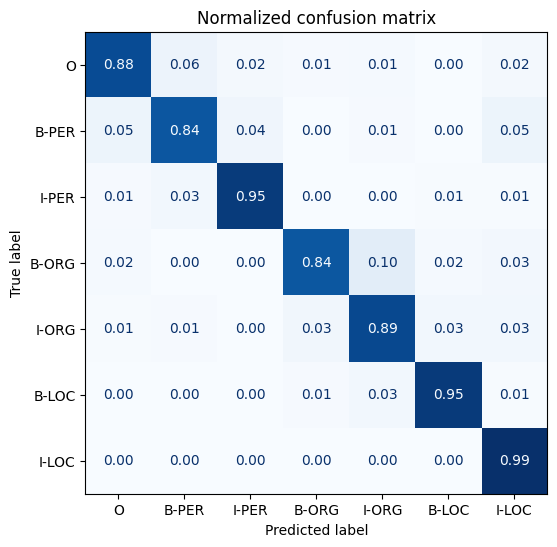

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix # Importa as funções para criar
    # e exibir matrizes de confusão do scikit-learn.
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_preds, y_true, labels): # Define uma função para plotar uma matriz de confusão normalizada.

 cm = confusion_matrix(y_true, y_preds, normalize="true") # Calcula a matriz de confusão normalizada,
    # onde cada célula representa a proporção de previsões para uma classe verdadeira.

 fig, ax = plt.subplots(figsize=(6, 6)) # Cria uma figura e um eixo para o gráfico, com um tamanho de 6x6 polegadas.

 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) # Cria um objeto ConfusionMatrixDisplay para exibir a matriz de confusão.

 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) # Plota a matriz de confusão usando o mapa de cores "Blues",
    # formatando os valores como números de ponto flutuante com 2 casas decimais, usando o eixo criado anteriormente e desativando a barra de cores.

 plt.title("Normalized confusion matrix") # Define o título do gráfico como "Normalized confusion matrix".

 plt.show() # Exibe o gráfico.

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names) # Chama a função plot_confusion_matrix
# para exibir a matriz de confusão, usando os rótulos verdadeiros da coluna "labels", os rótulos previstos da coluna
# "predicted_label" e os nomes das tags (classes) do objeto "tags".

vemos que B-PER e I-ORG estão sendo confundidos com I-LOC

além de ver que B-ORG está sendo confundido com I-ORG
___________

agora que examinamos os erros a nível de token, vamos observar as sequências com as maiores perdas.

Para esse calculo, vamos voltar aos dados não explodidos e calcular a perda total somando a perda por token

In [54]:
def get_samples(df): # Define uma função geradora chamada get_samples que recebe um DataFrame como entrada.

  for _, row in df.iterrows(): # Itera sobre cada linha do DataFrame.

    labels, preds, tokens, losses = [], [], [], [] # Inicializa listas vazias para armazenar rótulos, previsões, tokens e perdas.

    for i, mask in enumerate(row["attention_mask"]): # Itera sobre a máscara de atenção da linha, com o índice.
      if i not in {0, len(row["attention_mask"])}: # Verifica se o índice não é o primeiro (0)
          # nem o último elemento da máscara de atenção (para ignorar tokens especiais de início e fim).

        labels.append(row["labels"][i]) # Adiciona o rótulo verdadeiro ao array labels.
        preds.append(row["predicted_label"][i]) # Adiciona a previsão ao array preds.
        tokens.append(row["input_tokens"][i]) # Adiciona o token ao array tokens.
        losses.append(f"{row['loss'][i]:.2f}") # Adiciona a perda formatada (com 2 casas decimais) ao array losses.

    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T # Cria um DataFrame temporário
      # (transposto) com os tokens, rótulos, previsões e perdas.

    yield df_tmp # Retorna o DataFrame temporário como um gerador.


df["total_loss"] = df["loss"].apply(sum) # Cria uma nova coluna "total_loss" no DataFrame df, que contém a soma das perdas para cada sequência.

df_tmp = df.sort_values(by="total_loss", ascending=False).head(3) # Cria um novo DataFrame df_tmp contendo as 3 linhas com as maiores perdas totais.

for sample in get_samples(df_tmp): # Itera sobre os DataFrames gerados pela função get_samples.
  display(sample) # Exibe cada DataFrame gerado.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.95,0.00,0.00,7.13,9.38,9.77,7.51,0.00,8.54,9.42,8.65,7.43,5.75,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,4.68,0.00,0.00,0.00,10.79,9.40,7.26,5.07,6.00,0.00,7.21,7.50,0.00,7.53,7.66,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.70,6.47,6.45,0.00,6.37,0.00,6.20,0.00,6.05,5.79,6.02,6.17,6.30,6.27,0.00


É evidente que algo está errado com os rótulos dessas amostras; por exemplo, as Nações Unidas e a República Centro-Africana são rotuladas como pessoas!

Ao mesmo tempo, "8 de julho" no primeiro exemplo é rotulado como uma organização. Acontece que as anotações para o conjunto de dados PAN-X foram geradas por meio de um processo automatizado. Essas anotações são frequentemente referidas como "padrão prata" (em contraste com o "padrão ouro" de anotações geradas por humanos), e não é surpresa que existam casos em que a abordagem automatizada falhou em produzir rótulos sensatos.

Na verdade, tais modos de falha não são exclusivos de abordagens automáticas; mesmo quando humanos anotam dados cuidadosamente, erros podem ocorrer quando a concentração dos anotadores diminui ou eles simplesmente interpretam mal a frase.
_____________________

Outro problema notado por nós foram as perdas relativamente altas para parenteses e barras, vamos olhar os exemplos com parênteses abrindo

In [55]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
# Cria um novo DataFrame df_tmp que contém as duas primeiras linhas do DataFrame df
# onde a coluna "input_tokens" contém o token "\u2581(", que representa um espaço em branco seguido por um parêntese de abertura.
# A função apply aplica uma função lambda a cada valor na coluna "input_tokens",
# e a função lambda verifica se o token "\u2581(" está presente na lista de tokens.
# A função loc filtra as linhas do DataFrame df com base no resultado da função lambda.
# A função head(2) seleciona as duas primeiras linhas do resultado filtrado.

for sample in get_samples(df_tmp):
# Itera sobre os DataFrames gerados pela função get_samples, que formata cada linha do DataFrame df_tmp para exibição.
 display(sample)
# Exibe cada DataFrame formatado.

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.03,0.00,0.00,0.02,0.02,0.00,0.01,0.00


Em geral, não incluiríamos os parênteses e seu conteúdo como parte da entidade nomeada, mas esta parece ser a forma como a extração automática anotou os documentos.

Nos outros exemplos, os parênteses contêm uma especificação geográfica. Embora isso também seja de fato uma localização, podemos querer desconectá-la da localização original nas anotações.

Este conjunto de dados consiste em artigos da Wikipédia em diferentes idiomas, e os títulos dos artigos frequentemente contêm algum tipo de explicação entre parênteses.

Por exemplo, no primeiro exemplo, o texto entre parênteses indica que Hama é uma "Unternehmen", ou empresa em português.

Estes são detalhes importantes a saber quando implementamos o modelo, pois podem ter implicações no desempenho downstream de todo o pipeline do qual o modelo faz parte.

### Com uma análise relativamente simples, identificamos algumas fraquezas tanto em nosso modelo quanto no conjunto de dados. Em um caso de uso real, iteraríamos nesta etapa, limpando o conjunto de dados, retreinando o modelo e analisando os novos erros até que estivéssemos satisfeitos com o desempenho.

#  Cross-Lingual Transfer

agora que ajustamos XLM-R em alemão, podems avaliar suas abilidades em outras línguas pelo método predict() do Trainer. Como vamos avaliar várias línguas, então vamos criar uma função para isso

In [56]:
 def get_f1_score(trainer, dataset):
     return trainer.predict(dataset).metrics["test_f1"]

podemos usar a função para examinar a performance no conjunto de teste d armazenar a pontuação num dicionário

In [57]:
 f1_scores = defaultdict(dict)
 f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
 print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.865


podemos ver que nossas métricas estão em aproximadamente 85%, um bom resultado para NER.

o modelo parece ter maior dificuldade em entidades PER e ORG, provavelmente por que são pouco comuns e nos dados de treinamento e por que os nomes são raros no vocabulário do XLM-R.

### Vamos verificar como o modelo ajustado para alemão se dá em francês, italiano e inglês

In [58]:
 text_fr = "Jeff Dean est informaticien chez Google en Californie"
 tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


Nada mal! Embora o nome e a organização sejam os mesmos em ambos os idiomas, o modelo conseguiu rotular corretamente a tradução francesa de "Kalifornien". Em seguida, vamos quantificar o desempenho do nosso modelo alemão em todo o conjunto de teste francês, escrevendo uma função simples que codifica um conjunto de dados e gera o relatório de classificação nele:

In [59]:
def evaluate_lang_performance(lang, trainer):
  # Define uma função chamada evaluate_lang_performance que recebe o idioma (lang) e o treinador (trainer) como entrada.

  panx_ds = encode_panx_dataset(panx_ch[lang])
  # Codifica o conjunto de dados PAN-X para o idioma especificado usando a função encode_panx_dataset.
  # panx_ch é um dicionário que contém os conjuntos de dados PAN-X para diferentes idiomas.

  return get_f1_score(trainer, panx_ds["test"])
  # Retorna o F1-score do modelo treinado (trainer) no conjunto de teste do conjunto de dados codificado.
  # A função get_f1_score calcula o F1-score.

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
# Chama a função evaluate_lang_performance para avaliar o desempenho do modelo alemão (de) no conjunto de dados francês (fr).
# O resultado (F1-score) é armazenado no dicionário f1_scores.

print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")
# Imprime o F1-score do modelo alemão no conjunto de dados francês, formatado para três casas decimais.

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.703


Agora vamos avaliar o modelo em italiano

In [60]:
 f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
 print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.690


e por último em inglês

In [61]:
 f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
 print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.605


#  When Does Zero-Shot Transfer Make Sense?

## vamos fazer o seguinte experimento

Avaliação Inicial:

O modelo XLM-R, ajustado para alemão, alcança um F1-score de 85%.
Sem treinamento adicional, ele mostra um desempenho modesto em outros idiomas.


### Comparação e Análise:

O objetivo é comparar o desempenho do modelo ajustado em alemão com um modelo ajustado especificamente para francês.
Isso é feito ajustando o modelo em conjuntos de treinamento franceses de tamanhos crescentes.


Objetivo do Experimento:

Determinar em que ponto o "zero-shot cross-lingual transfer" (usar um modelo treinado em um idioma para outro sem treinamento adicional) é superior ao ajuste fino monolíngue (treinar o modelo especificamente para o idioma de destino).
Isso ajuda a decidir se é necessário coletar mais dados rotulados para o idioma de destino.


Metodologia:

Usar os mesmos hiperparâmetros do treinamento em alemão, ajustando apenas o registro de etapas para acomodar os tamanhos variáveis dos conjuntos de treinamento franceses.

Criar uma função que recebe um conjunto de dados monolíngue, reduz seu tamanho e ajusta o XLM-R nele, retornando as métricas do melhor período.

In [62]:
def train_on_subset(dataset, num_samples):

  # Define uma função chamada train_on_subset que recebe um dataset (DatasetDict) e o número de amostras (num_samples) para treinamento.

  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  # Cria um subconjunto do conjunto de treinamento, embaralhando-o com uma semente fixa (seed=42)
  # para reprodutibilidade e selecionando as primeiras num_samples amostras.

  valid_ds = dataset["validation"]
  # Obtém o conjunto de validação do dataset.

  test_ds = dataset["test"]
  # Obtém o conjunto de teste do dataset.

  training_args.logging_steps = len(train_ds) // batch_size
  # Ajusta o parâmetro logging_steps dos argumentos de treinamento para que o log seja feito uma vez por época.
  # len(train_ds) // batch_size calcula o número de passos de treinamento por época.

  trainer = Trainer(model_init=model_init, args=training_args,
                    data_collator=data_collator, compute_metrics=compute_metrics,
                    train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  # Inicializa o objeto Trainer, que gerencia o treinamento do modelo.
  # model_init: função que inicializa o modelo.
  # args: argumentos de treinamento.
  # data_collator: função que prepara os lotes de dados.
  # compute_metrics: função que calcula as métricas de avaliação.
  # train_dataset: o subconjunto de treinamento criado.
  # eval_dataset: o conjunto de validação.
  # tokenizer: o tokenizador usado.


  trainer.train()
  # Inicia o treinamento do modelo.

  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message="Training completed!")
  # Se push_to_hub estiver habilitado nos argumentos de treinamento, envia o modelo treinado para o Hugging Face Hub.

  f1_score = get_f1_score(trainer, test_ds)
  # Calcula o F1-score do modelo treinado no conjunto de teste.

  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})
  # Retorna um DataFrame pandas contendo o número de amostras usadas para treinamento e o F1-score resultante.

como fizemos ao ajustar ao corpus em alemão, vamos agora codificar o corpus em francês em ids de input, máscaras de atençãoe id de rótulo

In [63]:
 panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])


Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

vamos ver se nossa função funciona com um conjunto de treinamento de 250 exemplos, apenas

In [64]:
 training_args.push_to_hub = False
 metrics_df = train_on_subset(panx_fr_encoded, 250)
 metrics_df

<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.617700,1.286206,0.006162
2,1.182100,0.952519,0.268809
3,0.944800,0.876956,0.394899


,num_samples,f1_score
0,250,0.393931


nós podemos ver que, para apenas 250 exmplos, o ajuste em fracês não performa tão bem quanto o zero-shot transfer de alemão por uma margem bem grande.

vamos aumentar a nossa margem em 500, 1000, 2000 e 4000 para ver como a performance aumenta

In [65]:
 for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat(
    [metrics_df, train_on_subset(panx_fr_encoded, num_samples)],
    ignore_index=True
    )


<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.423400,0.998993,0.346610
2,0.816800,0.635208,0.586946
3,0.555900,0.545150,0.641086


<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.077800,0.532722,0.684900
2,0.458700,0.410312,0.734873
3,0.303900,0.386013,0.771716


<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.763900,0.377155,0.750449
2,0.314200,0.342726,0.774397
3,0.214500,0.333213,0.811270


<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.584500,0.345782,0.782032
2,0.279000,0.296325,0.814209
3,0.189800,0.282067,0.829898


vamos comparar como o fine-tuning em frnacês compara ao zero-shot cross lingual transfer do alemão

para isso, plotaremos os f1-scores no conjunto de testes em função do crescente tamanho do conjunto de testes

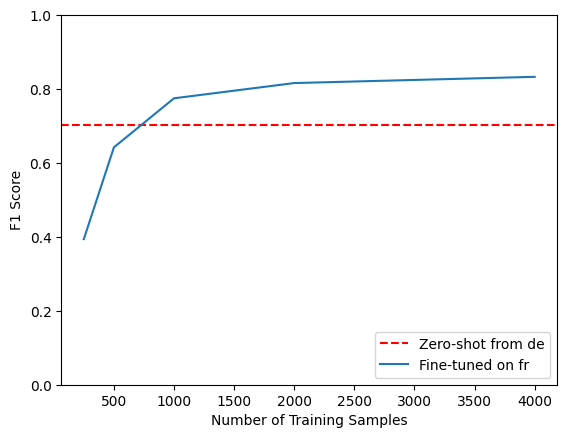

In [66]:
fig, ax = plt.subplots() # Cria uma nova figura e um eixo para o gráfico.

ax.axhline(f1_scores["de"]["fr"], ls="--", color="r") # Adiciona uma linha horizontal ao gráfico
# representando o F1-score do modelo alemão (de) no conjunto de dados francês (fr).
# ls="--" define o estilo da linha como tracejado e color="r" define a cor como vermelho.

metrics_df.set_index("num_samples").plot(ax=ax) # Plota o DataFrame metrics_df, usando a coluna "num_samples"
# como índice no eixo x e o F1-score no eixo y, usando o mesmo eixo criado anteriormente (ax).

plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right") # Adiciona uma legenda ao gráfico,
# identificando a linha horizontal como "Zero-shot from de" (desempenho sem treinamento adicional) e a
# linha do DataFrame como "Fine-tuned on fr" (desempenho com ajuste fino no francês), e posiciona a legenda no canto inferior direito.

plt.ylim((0, 1)) # Define os limites do eixo y para o intervalo de 0 a 1, já que o F1-score está nesse intervalo.

plt.xlabel("Number of Training Samples") # Define o rótulo do eixo x como "Number of Training Samples" (número de amostras de treinamento).

plt.ylabel("F1 Score") # Define o rótulo do eixo y como "F1 Score".

plt.show() # Exibe o gráfico.

pelo gráfico, podemos notar que o zeroshot transfer permanece competitivo até cerca de 750 exemplos de treino, onde o fine-tuning em frances alcança um nível de performance similar.

#  Fine-Tuning on Multiple Languages at Once

vimos que  zero-shot cross-lingual transfer do alemão para francês ou italiano produz uma queda de cerca de 15 pontos em performance.

uma maneira de mitigar isso é fazer o fine-tuning em multiplas linguas ao mesmo tempo.

vamos, então, concatenar os datasets dos corpora de alemão e francês

In [67]:
from datasets import concatenate_datasets # Importa a função concatenate_datasets do módulo datasets, usada para combinar conjuntos de dados.

def concatenate_splits(corpora):
  # Define uma função chamada concatenate_splits que recebe uma lista de conjuntos de dados (corpora) como entrada.

  multi_corpus = DatasetDict()
  # Inicializa um dicionário DatasetDict vazio chamado multi_corpus, que armazenará o conjunto de dados combinado.

  for split in corpora[0].keys():
    # Itera sobre os splits (divisões) do primeiro conjunto de dados na lista corpora. Os splits são "train", "validation" e "test".

    multi_corpus[split] = concatenate_datasets(
      [corpus[split] for corpus in corpora]).shuffle(seed=42)
      # Para cada split, concatena os splits correspondentes de todos os conjuntos de dados na lista corpora usando concatenate_datasets.
      # [corpus[split] for corpus in corpora] cria uma lista dos splits correspondentes de cada conjunto de dados.
      # .shuffle(seed=42) embaralha o conjunto de dados combinado com uma semente fixa (seed=42) para reprodutibilidade.

  return multi_corpus
  # Retorna o dicionário DatasetDict contendo os conjuntos de dados combinados e embaralhados.

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])
# Chama a função concatenate_splits para combinar os conjuntos de dados panx_de_encoded e panx_fr_encoded em um único
# conjunto de dados chamado panx_de_fr_encoded.
# O resultado é um DatasetDict onde cada split (train, validation, test) contém a concatenação dos splits correspondentes
# dos conjuntos de dados originais.
# Além disso, o conjunto de dados resultante é embaralhado.

para treinamento, vamos usar os mesmos hiperparâmetros

In [68]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
# Define o número de passos de log para o treinamento. O log será feito uma vez por época,
# calculando o número total de passos de treinamento (tamanho do conjunto de treinamento dividido pelo tamanho do lote).

training_args.push_to_hub = True
# Habilita o envio do modelo treinado para o Hugging Face Hub.

training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"
# Define o diretório de saída para o modelo treinado no Hugging Face Hub.

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])
# Inicializa o objeto Trainer, que gerencia o treinamento do modelo.
# model_init: função que inicializa o modelo.
# args: argumentos de treinamento definidos em training_args.
# data_collator: função que prepara os lotes de dados.
# compute_metrics: função que calcula as métricas de avaliação.
# tokenizer: o tokenizador usado.
# train_dataset: o conjunto de treinamento combinado (alemão e francês).
# eval_dataset: o conjunto de validação combinado (alemão e francês).

trainer.train()
# Inicia o treinamento do modelo usando o Trainer.

trainer.push_to_hub(commit_message="Training completed!")
# Envia o modelo treinado para o Hugging Face Hub com a mensagem de commit "Training completed!".

<ipython-input-68-45da2d851fae>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.284300,0.178425,0.828603
2,0.145300,0.162868,0.847724
3,0.094900,0.160756,0.861129


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/analluvias/xlm-roberta-base-finetuned-panx-de-fr/commit/2e969f02949c4d9d30bac52fc5345d9d0ff105bf', commit_message='Training completed!', commit_description='', oid='2e969f02949c4d9d30bac52fc5345d9d0ff105bf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/analluvias/xlm-roberta-base-finetuned-panx-de-fr', endpoint='https://huggingface.co', repo_type='model', repo_id='analluvias/xlm-roberta-base-finetuned-panx-de-fr'), pr_revision=None, pr_num=None)

vamos visualizar como o modelo performa com o conjunto de testes de cada linguagem

In [69]:
 for lang in langs:
     f1 = evaluate_lang_performance(lang, trainer)
     print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de] dataset: 0.867


F1-score of [de-fr] model on [fr] dataset: 0.865


F1-score of [de-fr] model on [it] dataset: 0.789


F1-score of [de-fr] model on [en] dataset: 0.686


podemos ver que ele performa bem melhor em francês do que antes.

De maneira interessante, podemos notar que as performances nas partes em italiano e inglês também melhoraram em 10 pontos.

Ou seja: treinar dados em outra língua melhora a performance em linguas não vistas.

Vamos concluir nossa análise comparando o desempenho do ajuste fino em cada idioma separadamente com o aprendizado multilíngue em todos os corpora. Como já realizamos o ajuste fino no corpus alemão, podemos realizar o ajuste fino nos idiomas restantes com nossa função train_on_subset(), com num_samples igual ao número de exemplos no conjunto de treinamento:

In [70]:
corpora = [panx_de_encoded]
 # Inicializa a lista 'corpora' com o corpus alemão já codificado.
 # Esta lista será usada para armazenar os corpora para análise posterior.

for lang in langs[1:]:
 # Itera sobre a lista de idiomas 'langs', começando do segundo elemento (índice 1).
 # Isso assume que o primeiro elemento de 'langs' é o idioma alemão, que já foi processado.

 training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
 # Define o diretório de saída para salvar os resultados do ajuste fino para o idioma atual.
 # O nome do diretório inclui o nome do modelo base e o código do idioma.

 ds_encoded = encode_panx_dataset(panx_ch[lang])
 # Codifica o conjunto de dados do PAN-X para o idioma atual usando a função 'encode_panx_dataset()'.

 metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
 # Realiza o ajuste fino do modelo no conjunto de dados codificado para o idioma atual.
 # A função 'train_on_subset()' é chamada com o conjunto de dados codificado e o número de exemplos de treinamento.
 # A variável 'metrics' provavelmente armazena as métricas de avaliação do treinamento.

 # Collect F1-scores in common dict
 f1_scores[lang][lang] = metrics["f1_score"][0]
 # Armazena a pontuação F1 (o primeiro elemento da lista 'f1_score' nas métricas)
 # no dicionário 'f1_scores', usando o código do idioma como chaves.

# Add monolingual corpus to list of corpora to concatenate
 corpora.append(ds_encoded)
 # Adiciona o corpus codificado para o idioma atual à lista 'corpora'.
 # Isso prepara a lista para potencialmente realizar uma análise ou treinamento multilíngue posterior.

<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.563700,0.321530,0.783748
2,0.266700,0.277881,0.829655
3,0.182000,0.277950,0.841128


No files have been modified since last commit. Skipping to prevent empty commit.


<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.760600,0.320134,0.748693
2,0.289500,0.272170,0.785714
3,0.183400,0.246469,0.829787


No files have been modified since last commit. Skipping to prevent empty commit.


<ipython-input-62-8d35f69f0e70>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.030800,0.497673,0.576490
2,0.487100,0.384756,0.680470
3,0.363000,0.387531,0.703495


No files have been modified since last commit. Skipping to prevent empty commit.


In [71]:
# juntando a lista de corpora do último passo
corpora_encoded = concatenate_splits(corpora)

In [72]:
# Define a frequência com que os logs de treinamento serão exibidos.
# training_args.logging_steps é definido como o número total de exemplos de treinamento
# dividido pelo tamanho do lote (batch_size). Isso geralmente resulta em um log
# sendo exibido várias vezes por época (epoch).
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size

# Define o diretório onde os arquivos de saída do treinamento serão salvos.
# Isso inclui o modelo treinado, logs, checkpoints, etc.
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

# Inicializa uma instância da classe Trainer da biblioteca transformers.
trainer = Trainer(
    # Especifica uma função para inicializar o modelo. Útil para inicialização personalizada.
    model_init=model_init,
    # Passa os argumentos de treinamento definidos anteriormente.
    args=training_args,
    # Especifica a função para agrupar as amostras de dados em lotes.
    data_collator=data_collator,
    # Indica a função para calcular as métricas de avaliação.
    compute_metrics=compute_metrics,
    # Fornece o tokenizador usado para pré-processar os dados.
    tokenizer=xlmr_tokenizer,
    # Fornece o conjunto de dados de treinamento codificado.
    train_dataset=corpora_encoded["train"],
    # Fornece o conjunto de dados de validação codificado para avaliação.
    eval_dataset=corpora_encoded["validation"]
)

# Inicia o processo de treinamento do modelo usando as configurações e dados fornecidos ao Trainer.
trainer.train()

# Envia o modelo treinado e os arquivos relacionados para o Hugging Face Hub.
# commit_message define a mensagem que será usada ao enviar o modelo.
trainer.push_to_hub(commit_message="Training completed!")

<ipython-input-72-2de1c449fc80>:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.293700,0.194225,0.814215
2,0.154400,0.165826,0.845967
3,0.099100,0.171881,0.856812


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/analluvias/xlm-roberta-base-finetuned-panx-all/commit/3cf1fd20b995ba3b7256d94fdb3628cc3635a9c7', commit_message='Training completed!', commit_description='', oid='3cf1fd20b995ba3b7256d94fdb3628cc3635a9c7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/analluvias/xlm-roberta-base-finetuned-panx-all', endpoint='https://huggingface.co', repo_type='model', repo_id='analluvias/xlm-roberta-base-finetuned-panx-all'), pr_revision=None, pr_num=None)

O passo final é gerar as previsões do treinador no conjunto de teste de cada idioma. Isso nos dará uma visão de quão bem o aprendizado multilíngue realmente está funcionando. Coletaremos as pontuações F1 em nosso dicionário f1_scores e, em seguida, criaremos um DataFrame que resume os principais resultados de nossos experimentos multilíngues.

In [73]:
# langs: uma lista de idiomas (ex: ["de", "en", "es"])
# corpora: uma lista de dicionários, onde cada dicionário contém os conjuntos de dados de treinamento e teste para um idioma
# trainer: o modelo treinado que você quer avaliar
# get_f1_score: uma função que calcula a pontuação F1 de um modelo em um conjunto de dados

for idx, lang in enumerate(langs):
    # Calcula a pontuação F1 do modelo treinado em todos os idiomas (trainer) no conjunto de teste de cada idioma
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

# Organiza as pontuações F1 em um dicionário para criar um DataFrame
scores_data = {
    "de": f1_scores["de"],  # Pontuações F1 quando treinado apenas em alemão
    "each": {lang: f1_scores[lang][lang] for lang in langs},  # Pontuações F1 para cada idioma treinado e testado individualmente
    "all": f1_scores["all"]  # Pontuações F1 quando treinado em todos os idiomas
}

# Cria um DataFrame do pandas a partir do dicionário scores_data
f1_scores_df = pd.DataFrame(scores_data).T.round(4)  # Transpõe e arredonda para 4 casas decimais

# Renomeia os eixos do DataFrame para melhor legibilidade
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on", inplace=True)

# Exibe o DataFrame resultante
print(f1_scores_df)

Evaluated on      de      fr      it      en
Fine-tune on                                
de            0.8646  0.7026  0.6899  0.6054
each          0.8646  0.8417  0.8174  0.6891
all           0.8660  0.8670  0.8758  0.7725


A partir desses resultados, podemos tirar algumas conclusões gerais:

1. O aprendizado multilíngue pode proporcionar ganhos significativos de desempenho, especialmente se os idiomas de baixo recurso para transferência entre línguas pertencerem a famílias linguísticas semelhantes. Em nossos experimentos, podemos ver que alemão, francês e italiano alcançam desempenho semelhante na categoria 'all', sugerindo que esses idiomas são mais semelhantes entre si do que ao inglês.


2. Como estratégia geral, é uma boa ideia concentrar a atenção na transferência entre línguas dentro de famílias linguísticas, especialmente ao lidar com scripts diferentes, como o japonês.